# Ajuste de hiperparámetros mediante búsqueda Grid-Search

En el notebook anterior, vimos que los hiperparámetros pueden afectar el rendimiento de generalización de un modelo. En este notebook, mostramos cómo optimizar los hiperparámetros utilizando un enfoque de búsqueda Grid-Search.

## Nuestro modelo predictivo

Recargamos el conjunto de datos como hicimos anteriormente:

In [1]:
import pandas as pd

adult_census = pd.read_csv("adult_census.csv")

Extraemos la columna que contiene la variable objetivo.

In [2]:
target_name = "class"
target = adult_census[target_name]
target

,class
0,<=50K
1,<=50K
2,>50K
3,>50K
4,<=50K
...,...
48837,<=50K
48838,>50K
48839,<=50K
48840,<=50K


Eliminamos de nuestros datos la variable objetivo y la columna `"education-num"`
que duplica la información de la columna `"education"`.

In [3]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,id,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,2,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,3,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,4,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,5,18,?,103497,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


Una vez cargado el conjunto de datos, lo dividimos en conjuntos de entrenamiento y prueba.

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

Definimos un pipeline para manejar tanto las características
numéricas como las categóricas.

El primer paso es seleccionar todas las columnas categóricas.

In [5]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

Aquí utilizamos un modelo basado en árboles como clasificador (es decir,
`HistGradientBoostingClassifier`). Esto significa:

* Las variables numéricas no necesitan escalado;
* Las variables categóricas pueden manejarse con un `OrdinalEncoder` incluso si el
  orden de codificación no es significativo;
* Para los modelos basados en árboles, el `OrdinalEncoder` evita tener representaciones
  de alta dimensión.

Ahora construimos nuestro `OrdinalEncoder` pasándole las categorías conocidas.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

Luego usamos un `ColumnTransformer` para seleccionar las columnas categóricas y aplicar
el `OrdinalEncoder` a ellas.

In [7]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
    force_int_remainder_cols=False
)

Finalmente, utilizamos un clasificador basado en árboles (es decir, gradient-boosting de histograma) para
predecir si una persona gana más de 50 k$ al año o no.

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Ajuste mediante búsqueda Grid-Search

En el ejercicio anterior, utilizamos un bucle `for` por cada hiperparámetro para
encontrar la mejor combinación entre algunos valores fijos. `GridSearchCV` es una clase de scikit-learn que implementa una lógica muy similar con menos código repetitivo.

Veamos cómo usar el estimador `GridSearchCV` para realizar dicha búsqueda. Dado que la búsqueda grid-search es costosa, solo exploramos la combinación de tasa de aprendizaje (`learning_rate`) y el número máximo de nodos (`max_leaf_nodes`).

In [9]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),
    "classifier__max_leaf_nodes": (3, 10, 30),
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

CPU times: user 1.67 s, sys: 67.5 ms, total: 1.74 s
Wall time: 15 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

Finalmente, comprobamos la precisión de nuestro modelo utilizando el conjunto de prueba.

In [10]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"La puntuación de precisión en el conjunto de prueba del pipeline con búsqueda grid-search es: {accuracy:.2f}"
)

La puntuación de precisión en el conjunto de prueba del pipeline con búsqueda grid-search es: 0.88


**Advertencia:**
Ten en cuenta que la evaluación normalmente debe realizarse mediante
validación cruzada proporcionando `model_grid_search` como modelo a la
función `cross_validate`. Aquí, utilizamos una única división de entrenamiento-prueba para evaluar `model_grid_search`. En un futuro notebook profundizaremos en la validación cruzada anidada (nested cross-validation), cuando se utiliza la validación cruzada tanto para el ajuste de hiperparámetros como para la evaluación del modelo.

El estimador `GridSearchCV` toma un parámetro `param_grid` que define todos
los hiperparámetros y sus valores asociados. La búsqueda grid-search se encarga
de crear todas las combinaciones posibles y probarlas.

El número de combinaciones es igual al producto del número de valores a
explorar para cada parámetro (por ejemplo, en este ejercicio fueron 4 x 3 combinaciones). Por lo tanto, añadir nuevos parámetros con sus valores asociados a explorar se vuelve rápidamente costoso computacionalmente.

Una vez que el grid-search se ha ajustado (`fitted`), puede utilizarse como cualquier otro predictor llamando a
`predict` y `predict_proba`. Internamente, utiliza el modelo con los
mejores parámetros encontrados durante `fit`.

Obtenemos predicciones para las 5 primeras muestras utilizando el estimador con los mejores parámetros.

In [11]:
model_grid_search.predict(data_test.iloc[0:5])

array(['<=50K', '<=50K', '>50K', '<=50K', '>50K'], dtype=object)

Puedes conocer estos parámetros mirando el atributo `best_params_`.

In [12]:
print(f"El mejor conjunto de parámetros es: {model_grid_search.best_params_}")

El mejor conjunto de parámetros es: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


La precisión y los mejores parámetros del pipeline con búsqueda grid-search son similares a los que encontramos en el ejercicio anterior, donde buscamos los mejores parámetros "a mano" a través de un doble bucle `for`.

Además, podemos inspeccionar todos los resultados que se almacenan en el atributo `cv_results_` del grid-search. Filtramos algunas columnas específicas de estos resultados.

In [13]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,1.340179,0.172853,0.403704,0.062902,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.867165,0.866175,0.866670,0.000495,1
4,1.099063,0.079317,0.552654,0.071231,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.865746,0.866175,0.865961,0.000215,2
6,0.289612,0.002578,0.185415,0.016416,1.0,3,"{'classifier__learning_rate': 1, 'classifier__...",0.860559,0.861261,0.860910,0.000351,3
7,0.239993,0.003225,0.150638,0.003614,1.0,10,"{'classifier__learning_rate': 1, 'classifier__...",0.857229,0.853180,0.855205,0.002024,4
3,0.491817,0.010592,0.348386,0.021309,0.1,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.854272,0.853512,0.000760,5


Centrémonos en las columnas más interesantes y acortemos los nombres de los parámetros
para eliminar el prefijo `"param_classifier__"` para facilitar la lectura:

In [14]:
# obtener los nombres de los parámetros
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [15]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.10,30,0.866670,0.000495,1
4,0.10,10,0.865961,0.000215,2
6,1.00,3,0.860910,0.000351,3
7,1.00,10,0.855205,0.002024,4
3,0.10,3,0.853512,0.000760,5
8,1.00,30,0.846687,0.001861,6
2,0.01,30,0.845459,0.002207,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
10,10.00,10,0.618080,0.124277,10


Con solo 2 parámetros, es posible que queramos visualizar la búsqueda grid-search como un mapa de calor (heatmap). Para ello, necesitamos transformar nuestros `cv_results` en un DataFrame donde:

- las filas correspondan a los valores de la tasa de aprendizaje (`learning_rate`);
- las columnas correspondan al número máximo de hojas (`max_leaf_nodes`);
- el contenido del DataFrame sea la media de las puntuaciones de prueba.

In [16]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.845459
0.10,0.853512,0.865961,0.866670
1.00,0.860910,0.855205,0.846687
10.00,0.283476,0.618080,0.351369


Podemos utilizar una representación de mapa de calor (heatmap) para mostrar visualmente el DataFrame anterior.

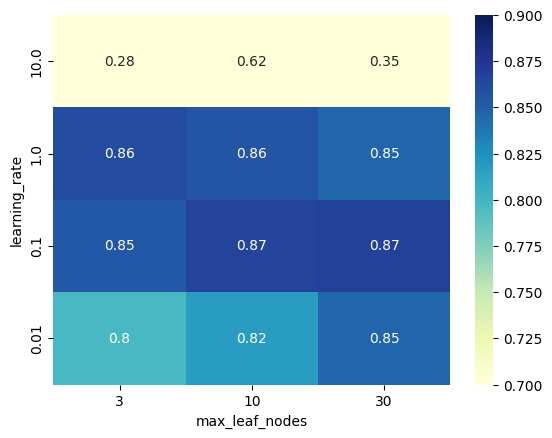

In [17]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7, vmax=0.9
)
ax.invert_yaxis()

La tabla anterior destaca los siguientes puntos:

* para valores demasiado altos de `learning_rate`, el rendimiento de generalización del modelo se degrada y ajustar el valor de `max_leaf_nodes` no puede solucionar ese problema;
* fuera de esta región problemática, observamos que la elección óptima de
  `max_leaf_nodes` depende del valor de `learning_rate`;
* en particular, observamos una "diagonal" de buenos modelos con una precisión cercana al máximo de 0.87: cuando se aumenta el valor de `max_leaf_nodes`, se debería disminuir el valor de `learning_rate` en consecuencia para preservar una buena precisión.

El significado preciso de estos dos parámetros se explicará más adelante.

Por ahora, observamos que, en general, **no hay un único ajuste de parámetros óptimo**: 4 modelos de las 12 configuraciones de parámetros alcanzan el mejor desempeño.

En este notebook hemos visto:

* cómo optimizar los hiperparámetros de un modelo predictivo mediante una búsqueda grid-search;
* buscar más de dos hiperparámetros es demasiado costoso con este método;
* una búsqueda grid-search no necesariamente encuentra una solución única y óptima.